In [ ]:
# requirements
!pip install -q rdflib sparqlwrapper owlrl gdown pandas wikipedia-api
!pip install --upgrade wikipedia-api
!apt install graphviz libgraphviz-dev > /dev/null
!pip install --quiet rdflib networkx pygraphviz
!mkdir -p images
!pip freeze > requirements.txt

In [ ]:
conda install --channel conda-forge pygraphviz

In [ ]:
import gdown
import os
import pandas as pd
from rdflib import Graph, URIRef, BNode, Literal, FOAF, RDF, RDFS, OWL, XSD, Namespace
from SPARQLWrapper import SPARQLWrapper

from datetime import datetime
import numpy as np
import math
import wikipediaapi
import owlrl
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph, rdflib_to_networkx_digraph
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image

In [ ]:
# create directory for data
if not os.path.exists("./data/"):
    os.mkdir("./data/")

In [ ]:
# Download data
gdown.download(id="1UILSMenvqzFMsIhV6l4ZV1opJpRQZnwC", output="./data/rym_top_5000_all_time.csv", quiet=True)
gdown.download(id="1UNJ2iDX-xoWIekSA0ZwoqNOk3eAZjqrp", output="./data/albumlist.csv", quiet=True)

'./data/albumlist.csv'

In [ ]:
# Move the checkpoint graphs to the folder 'data'
! mv /content/graph_01.ttl /content/data
! mv /content/graph_02.ttl /content/data
! mv /content/graph_03.ttl /content/data
! mv /content/graph_04.ttl /content/data
! mv /content/graph_05.ttl /content/data
! mv /content/graph_06.ttl /content/data
! mv /content/graph_07.ttl /content/data
! mv /content/graph_08.ttl /content/data
! mv /content/graph_09.ttl /content/data
! mv /content/graph_10.ttl /content/data

# **KRR Module 2 2022/23 Project**

The project consists in the creation of an RDF knowledge graph starting from tabular data (two CSV files).

## **`1. Create an RDFLib Graph from data contained in CSV files`**

### 1.1 ) Load the CSV files in two pandas DataFrames and join them

In [ ]:
df1 = pd.read_csv('data/albumlist.csv', encoding='mac_roman')
df1.head()

,Number,Year,Album,Artist,Genre,Subgenre
0,1,1967,Sgt. Pepper's Lonely Hearts Club Band,The Beatles,Rock,"Rock & Roll, Psychedelic Rock"
1,2,1966,Pet Sounds,The Beach Boys,Rock,"Pop Rock, Psychedelic Rock"
2,3,1966,Revolver,The Beatles,Rock,"Psychedelic Rock, Pop Rock"
3,4,1965,Highway 61 Revisited,Bob Dylan,Rock,"Folk Rock, Blues Rock"
4,5,1965,Rubber Soul,The Beatles,"Rock, Pop",Pop Rock


In [ ]:
df2 = pd.read_csv('data/rym_top_5000_all_time.csv')
df2.head()

,Ranking,Album,Artist Name,Release Date,Genres,Descriptors,Average Rating,Number of Ratings,Number of Reviews
0,1.0,OK Computer,Radiohead,16 June 1997,"Alternative Rock, Art Rock","melancholic, anxious, futuristic, alienation, ...",4.23,"70,382",1531
1,2.0,Wish You Were Here,Pink Floyd,12 September 1975,"Progressive Rock, Art Rock","melancholic, atmospheric, progressive, male vo...",4.29,"48,662",983
2,3.0,In the Court of the Crimson King,King Crimson,10 October 1969,"Progressive Rock, Art Rock","fantasy, epic, progressive, philosophical, com...",4.30,"44,943",870
3,4.0,Kid A,Radiohead,3 October 2000,"Art Rock, Experimental Rock, Electronic","cold, melancholic, futuristic, atmospheric, an...",4.21,"58,590",734
4,5.0,To Pimp a Butterfly,Kendrick Lamar,15 March 2015,"Conscious Hip Hop, West Coast Hip Hop, Jazz Rap","political, conscious, poetic, protest, concept...",4.27,"44,206",379


In [ ]:
df1.shape, df2.shape

((500, 6), (5000, 9))

In [ ]:
# Check if all elements in 'Album' column are unique
is_unique_df1 = not df1['Album'].duplicated().any()
is_unique_df2 = not df2['Album'].duplicated().any()

print(f"All elements of df1['Album'] are unique: {is_unique_df1} \nAll elements of df2['Album'] are unique: {is_unique_df2}")

All elements of df1['Album'] are unique: False 
All elements of df2['Album'] are unique: False


In [ ]:
# Check if all elements of df1['Album'] are present in df2['Album']
all_present = df1['Album'].isin(df2['Album']).all()

print(f"All elements of df1['Album'] are present in df2['Album']: {all_present}")

All elements of df1['Album'] are present in df2['Album']: False


The elements in the `Album` column are not unique, in both the dataframes, so if there are duplicates I can't join on the `Album` column.

Since I don't have that df2 contains each album in df1, I can't apply a left or right join, but I should apply an outer join.

In [ ]:
# Check if all pairs of elements from 'Name' and 'Age' columns are unique
is_unique_df1 = not df1.duplicated(subset=['Album', 'Artist']).any()
is_unique_df2 = not df2.duplicated(subset=['Album', 'Artist Name']).any()

print(f"All pairs of elements df1['Album', 'Artist'] are unique: {is_unique_df1} \nAll pairs of elements df2['Album', 'Artist Name'] are unique: {is_unique_df2}")

All pairs of elements df1['Album', 'Artist'] are unique: True 
All pairs of elements df2['Album', 'Artist Name'] are unique: False


In [ ]:
# DataFrame with the elements that have a duplicated pair df2['Album', 'Artist Name']
duplicated_pairs_df2 = df2[df2.duplicated(subset=['Album', 'Artist Name'], keep=False)]

duplicated_pairs_df2.shape

(23, 9)

In [ ]:
# Find the common pairs between df1 and duplicated_pairs_df2
# (All pairs of elements ['Album', 'Artist Name'] in df2 that are not unique, that we have also in df1)
common_pairs = df1.merge(duplicated_pairs_df2, left_on=['Album', 'Artist'], right_on=['Album', 'Artist Name'])

if common_pairs.empty:
  print("All pairs of elements df2['Album', 'Artist Name'] that are not unique, are not present in df1.")

All pairs of elements df2['Album', 'Artist Name'] that are not unique, are not present in df1.


After some further analysis, I know that in df2 I have some row that have the same pair `['Album', 'Artist Name']`; but fortunately none of this pairs appear in any row of df1.

Now the last step that remains is to find a way to solve this issue with the duplicated elements in df2, so that at the end I can merge the two DataFrames in the best way possible.

A possible way is to assign a general name, like `Album{N}`, so that I can create a new index based on the couple of columns `['Album', 'Artist Name']`, that after our changes doesn't have any duplicate.

In [ ]:
# In "duplicated_pairs_df2" I have the elements that have a duplicated pair df2['Album', 'Artist Name']
# duplicated_pairs_df2 = df2[df2.duplicated(subset=['Album', 'Artist Name'], keep=False)]    (I have already run it in the previous cell)

# Now I retrieve the indexes of the rows that I have to change
row_indexes = duplicated_pairs_df2.index.tolist()

# Change the values of specific rows in the 'Album' column
# As new values for the corresponding rows I will use ['Album0', 'Album1'...]
new_names = list()
for N in range(len(row_indexes)):
  new_names.append(f'Album{N}')

df2.loc[row_indexes, 'Album'] = new_names

Finally I merge the two DataFrames.

I set the couple `['Album', 'Artist']` as index, since after our changes each of this couples is unique. Then I merge on the index, that is faster then merging on simple columns.

The result is the outer join of the two DataFrames.

In [ ]:
# I rename the 'Artist Name' column of df2 to 'Artist' name, so it is equal to the DataFrame df1
df2 = df2.rename(columns={'Artist Name': 'Artist'})

df1.set_index(['Album', 'Artist'], inplace=True)
df2.set_index(['Album', 'Artist'], inplace=True)

df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how='outer')

In [ ]:
df_merged.head()

,,Number,Year,Genre,Subgenre,Ranking,Release Date,Genres,Descriptors,Average Rating,Number of Ratings,Number of Reviews
Album,Artist,,,,,,,,,,,
!!Destroy-Oh-Boy!!,New Bomb Turks,NaN,NaN,NaN,NaN,4872.0,1993,"Garage Punk, Punk Rock","energetic, humorous, sarcastic, male vocals, p...",3.69,676,14.0
"""Al final de este viaje...""",Silvio Rodríguez,NaN,NaN,NaN,NaN,682.0,1978,Nueva trova,"acoustic, passionate, male vocals, poetic, con...",3.91,"1,489",33.0
"""Born Into Trouble as the Sparks Fly Upward.""",The Silver Mt. Zion Memorial Orchestra & Tra-La-La Band,NaN,NaN,NaN,NaN,4763.0,23 October 2001,Post-Rock,"melancholic, apocalyptic, suspenseful, atmosph...",3.65,"3,982",51.0
"""Chrono Trigger""",Yasunori Mitsuda,NaN,NaN,NaN,NaN,240.0,25 March 1995,"Video Game Music, 16-bit","epic, fantasy, instrumental, eclectic, atmosph...",4.01,"1,689",25.0
"""Heroes""",David Bowie,NaN,NaN,NaN,NaN,155.0,14 October 1977,Art Rock,"futuristic, atmospheric, male vocals, anxious,...",3.97,"22,443",292.0


In [ ]:
df_merged.shape

(5205, 11)

In [ ]:
df_merged.to_csv('data/merged_dataframe.csv', index=True)

### 1.2 ) Create an RDFLib `Graph` and add triples from the data of the dataframes

I start creating:
  
*   an RDFLib `Graph`,
*   the namespace `df` that we will use to add the elements of our merged dataframe to the graph,
*   the URIs that we will use as predicate and class.


In [ ]:
# Create our graph
rdf_graph = Graph()
df = Namespace('http://example.org/DataFrame/')
rdf_graph.namespace_manager.bind('df', 'http://example.org/DataFrame/')

# Create some URI that I will use as predicate or object for my triples
df['Album']
df['Artist']
df['Genre']
df['artist']
df['releaseDate']
df['year']
df['genre']
df['subgenre']
df['descriptors']
df['rsRanking']
df['rymRanking']
df['averageRating']
df['numberOfRatings']
df['numberOfReviews']

rdflib.term.URIRef('http://example.org/DataFrame/numberOfReviews')

I will have something of this kind:

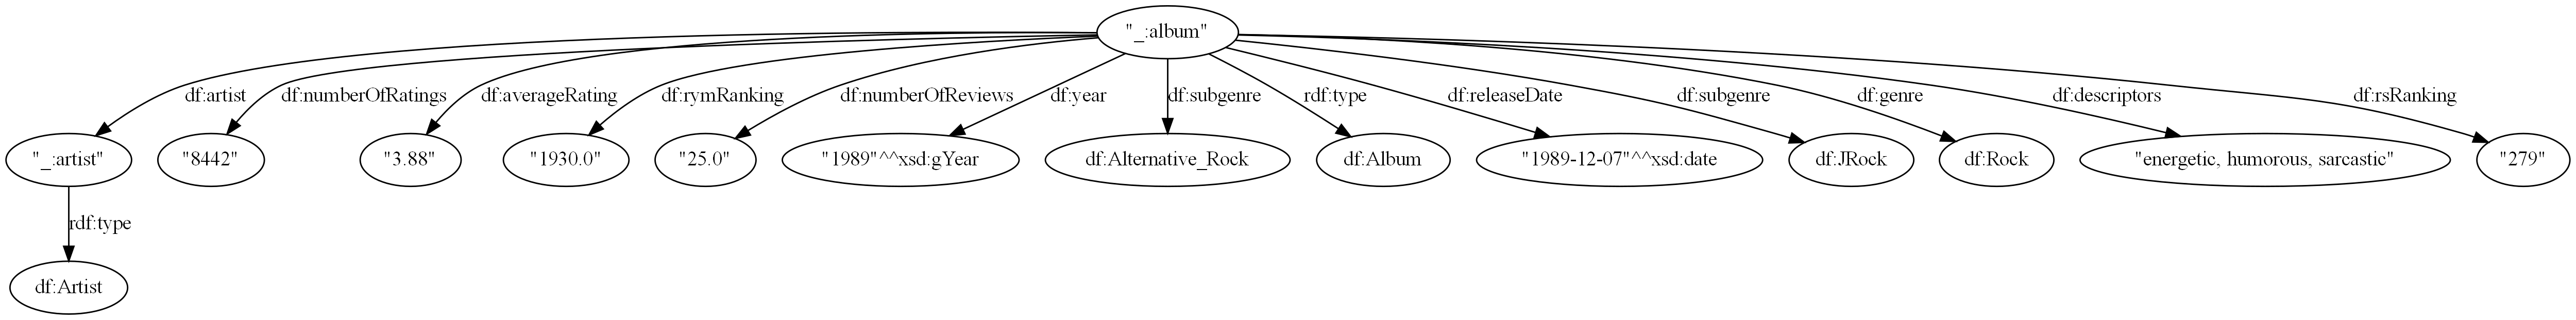

In [ ]:
# Visualizing a sample graph
g_sample = Graph()
df = Namespace('http://example.org/DataFrame/')
g_sample.namespace_manager.bind('df', 'http://example.org/DataFrame/')

album_uri = Literal("_:album")
data = (
    (album_uri, RDF.type, df.Album),
    (album_uri, df.artist, Literal("_:artist")),
    (Literal("_:artist"), RDF.type, df.Artist),
    (album_uri, df.averageRating, Literal("3.88")),
    (album_uri, df.numberOfRatings, Literal("8442")),
    (album_uri, df.numberOfReviews, Literal("25.0")),
    (album_uri, df.rymRanking, Literal("1930.0")),
    (album_uri, df.rsRanking, Literal("279")),
    (album_uri, df.releaseDate, Literal("1989-12-07", datatype=XSD.date)),
    (album_uri, df.year, Literal("1989", datatype=XSD.gYear)),
    (album_uri, df.genre, df.Rock),
    (album_uri, df.subgenre, df.JRock),
    (album_uri, df.subgenre, df.Alternative_Rock),
    (album_uri, df.descriptors, Literal("energetic, humorous, sarcastic"))
)
for triple in data:
    g_sample.add(triple)

G_sample = rdflib_to_networkx_multidigraph(g_sample, edge_attrs = lambda s, p, o: {"label" : p.n3(g_sample.namespace_manager)})
mapping = {node: node.n3(g_sample.namespace_manager) for node in G_sample.nodes}
G_sample = nx.relabel_nodes(G_sample, mapping)
A = nx.nx_agraph.to_agraph(G_sample)
A.draw("images/example.png", prog='dot', args="-Gdpi=1000 -Gsize=5")
Image("images/example.png")

**FUNCTIONS**

I create some function that will transform the simple literals and integers that I have in the tables in a form that will be useful for adding them in the graph.

In the URIs for the album and the artist I will replace spaces with underscore `_`, removes the quotes `"` and the accents. And I will link those URIs with an `RDFS.label`, which contains again the artist and the album, but as `datatype=XSD.string`.

For the floats values I have to remove the comma `,` since in the column `Number of Ratings` it is used for representing the thousands.

Language tagged strings are simply added as strings and `lang="en"`, and will be used in particular for the descriptors

In [ ]:
# Here I create the functions that will transform the values in the dataframe
### URI:
def value_to_uri(value):
    modified_string = value.replace(" ", "_")
    modified_string = modified_string.replace('"', '')
    modified_string = modified_string.replace('à', 'a')
    modified_string = modified_string.replace('ã', 'a')
    modified_string = modified_string.replace('ä', 'a')
    modified_string = modified_string.replace('é', 'e')
    modified_string = modified_string.replace('è', 'e')
    modified_string = modified_string.replace('ï', 'i')
    modified_string = modified_string.replace('í', 'i')
    modified_string = modified_string.replace('ò', 'o')
    modified_string = modified_string.replace('ö', 'o')
    modified_string = modified_string.replace('ù', 'u')
    modified_string = modified_string.replace('ü', 'u')
    modified_string = modified_string.replace('ç', 'c')
    return df[ modified_string ]

### Float:
def value_to_float(value):
    # I have to remove the comma (representing the thousands),
    # so I first transform into a string so that I can use the replace() method
    value_to_str = str(value)
    value_whitout_comma = value_to_str.replace(",", "")
    value_float = float(value_whitout_comma)
    return Literal(value_float, datatype=XSD.float)


### Language tagged string:
def value_to_tagged_string(value):
    value_string = str(value)
    return Literal(value_string, lang="en")


The function that will transform the date and the years take into considerations more cases, since the the column `'Release Date'`, the dates appears in many formats, therefore to transfer this data in the cleanest way into my graph I will:


*   transforme the dates in the format YYYY-MM-DD and use them as `datatype=XSD.date`,
*   if I have simply the year, I will use the format YYYY, as `datatype=XSD.gYear`.

In particular in the column `['Date']` I can have the date in the format 'DD month YYYY' or 'month YYYY' or 'YYYY', while in `['Year']` simply 'YYYY' (as a float). In the rows in which I don't have a value for the year, I will extract the information from the date column, and use that one.

In [ ]:
# Check if a value is "NaN"
def is_nan(value):
    if isinstance(value, str) or isinstance(value, int):
        return False
    return math.isnan(value)

In [ ]:
### Date and Year, with xsd:date and xsd:gYear:
# The following function check if the format of date_string matches the date_format
def is_valid_date_format(date_string, date_format):
    try:
        datetime.strptime(date_string, date_format)
        return True
    except:
        return False

# Input 1: Date, Input 2: Year
# Output 1: Date, Output 2: Year
def value_to_date_year(date_value, year_value):

    # If I have only the year
    if is_nan(date_value):
        year_value = int(year_value)
        return None, Literal(year_value, datatype=XSD.gYear)

    # If I have only the date
    # I extract the year from it
    elif is_nan(year_value):
        # check each format one by one
        # Day, month and year
        if is_valid_date_format(date_value, '%d %B %Y'):
            # Convert string to datetime object
            date_object = datetime.strptime(date_value, '%d %B %Y')
            # Convert datetime object to desired string format 'yyyy-mm-dd'
            output_date = date_object.strftime('%Y-%m-%d')
            # Extract the year in the format 'yyyy'
            output_year = date_object.strftime('%Y')
            return Literal(output_date, datatype=XSD.date), Literal(output_year, datatype=XSD.gYear)
        # Repeat with the other formats
        # Month and year
        elif is_valid_date_format(date_value, '%B %Y'):
            date_object = datetime.strptime(date_value, '%B %Y')
            output_date = date_object.strftime('%Y-%m-%d')
            output_year = date_object.strftime('%Y')
            return Literal(output_date, datatype=XSD.date), Literal(output_year, datatype=XSD.gYear)
        # If I have only the year, I will use it as datatype=XSD.gYear
        elif is_valid_date_format(date_value, '%Y'):
            return None, Literal(date_value, datatype=XSD.gYear)

    # If I have both, I do similarly to the previous point, but I give as result also the year value, taked from ['Year'] column
    else:
        year_value = int(year_value)
        if is_valid_date_format(date_value, '%d %B %Y'):
            date_object = datetime.strptime(date_value, '%d %B %Y')
            output_date = date_object.strftime('%Y-%m-%d')
            return Literal(output_date, datatype=XSD.date), Literal(year_value, datatype=XSD.gYear)

        elif is_valid_date_format(date_value, '%B %Y'):
            date_object = datetime.strptime(date_value, '%B %Y')
            output_date = date_object.strftime('%Y-%m-%d')
            return Literal(output_date, datatype=XSD.date), Literal(year_value, datatype=XSD.gYear)

        # In this case I will maintain only the value from the year column
        elif is_valid_date_format(date_value, '%Y'):
            return None, Literal(year_value, datatype=XSD.gYear)

The function that will handle the columns `['Genre', 'Subgenre']` from df1 and `['Genres']` from df2 will work in the following way.

I will use only two predicate, `df.genre` and `df.subgenre`

For each album:

*   if I have only `['Genre', 'Subgenre']`, use directly them as `df.genre` and `df.subgenre`,
*   if I have only `['Genres']`, I will extract the main genre for `df.genre` and put everything that I have in `['Genres']` as `df.subgenre`,
*   if I have both I will integrate the elements in `['Genre', 'Subgenre']` by adding the ones in `['Genres']`.

For each element I need to parse it, to obtain each genre separatly. My idea is to collect every genre in a dictionary, so that I can check if one of this value is present in `['Genres']`, so that I can extract it as main genre, and then put the others as subgenres.



----------


Build a dictionary which collect every genre that I have in the column `['Genre']`:

I create a duplicate column of `['Genre']` as a separate series, remove all the `NaN` values and do some operations:

after I want to split each list-value of my dictionary (since some element of my series have more than one genre), so I have to change some special character that appears in my values

*   Replace `', & '` with `', '`, since it appears for ex. `'Folk, World, & Country'`, but also `'Stage & Screen'` which is a unique genre that I don't want to split,
*   Replace `' / '` with `', '`, since it appears for ex. `'Funk / Soul'`,
*   Replace `'\xa0'` with `' '`, since it appears for ex. `'Rock,\xa0Pop'`,

Then `split(', ')`, convert my modified series into a dictionary, split each list which appear as value in my dictionary as multiple key-value (with as value we have a simple string), finally eliminate duplicated values and rename the keys.

For each genre I will attach an `RDFS.label` with the name of the genre as `datatype=XSD.string`

In [ ]:
# Build A dictionary with the genres

# Create a duplicate column as a separated Series
genre_column_copy = df_merged['Genre'].copy()

# Remove NaN values from the Series
genre_column_without_nan = genre_column_copy.dropna()

# Replace ', & ' with ', '
# Replace ' / ' with ', '
# in each value of the Series
genre_column_modified = genre_column_without_nan.apply(lambda x: x.replace(', & ', ', '))
genre_column_modified = genre_column_modified.apply(lambda x: x.replace(' / ', ', '))
genre_column_modified = genre_column_modified.apply(lambda x: x.replace('\xa0', ' '))

# Split the values in the duplicated column
genre_column_splitted = genre_column_modified.str.split(', ')

# Convert the duplicated column to a dictionary
genre_column_dict_list = genre_column_splitted.to_dict()

# Split each value in the original dictionary
# and store it in a new dictionary, with each value splitted (insted of having lists of values)
genre_dict_with_duplicates = {}

for key, values in genre_column_dict_list.items():
    for value in values:
        new_key = f'{key}_{value}'
        genre_dict_with_duplicates[new_key] = value

# Create a set to store unique values
unique_values = set()

# Filter out duplicate values from the dictionary
genre_dict_with_index_as_keys = {key: value for key, value in genre_dict_with_duplicates.items() if value not in unique_values and not unique_values.add(value)}

# Create a new dictionary with renamed keys
genre_dict = {str(i+1): value for i, (_, value) in enumerate(genre_dict_with_index_as_keys.items())}


In [ ]:
print("Here I have my genres:")
for key, value in genre_dict.items():
    print(f'{key}: {value}')

Here I have my genres:
1: Rock
2: Pop
3: Funk
4: Soul
5: Hip Hop
6: Folk
7: World
8: Country
9: Jazz
10: Electronic
11: Stage & Screen
12: Latin
13: Blues
14: Reggae
15: Classical


In [ ]:
# 'genre 1, genre 2' -> 'genre_1,_genre_2' -> ['genre_1', 'genre_2']
def value_to_correct_format(value):
    # Replace /
    value_modified = value.replace(" / ", ", ")
    # Replace &
    value_modified = value_modified.replace(', & ', ', ')
    # Replace spaces
    value_modified = value_modified.replace(" ", "_")
    # Split the string into individual words
    value_list = value_modified.split(',_')
    return value_list

In [ ]:
# Input 1: Genre_df1, Input 2: Subgenre_df1, Input 3: Genres_df2
# As output I return lists, than I will get each value by doing an iteraton when I build the graph
# Output 1: Genre_list, Output 2: Subgenre_list
def value_to_genre_subgenre(genre_df1_value, subgenre_df1_value, genres_df2_value):
    # If I have only genre and subgenre
    if is_nan(genres_df2_value):
        # Put in the correct format
        genre_list = value_to_correct_format(genre_df1_value)
        subgenre_list = value_to_correct_format(subgenre_df1_value)
        return genre_list, subgenre_list

    # If I have only genres
    elif is_nan(genre_df1_value):
        # Find all values from the dictionary that appear in the string
        genre_list = [value for value in genre_dict.values() if str(value) in genres_df2_value]

        # Store each genres as subgenre
        subgenre_list = value_to_correct_format(genres_df2_value)
        return genre_list, subgenre_list

    # If I have both
    # I do as in the two previous cases, but I sum the two results
    else:
        genre_list_1 = value_to_correct_format(genre_df1_value)
        subgenre_list_1 = value_to_correct_format(subgenre_df1_value)

        genre_list_2 = [value for value in genre_dict.values() if str(value) in genres_df2_value]
        subgenre_list_2 = value_to_correct_format(genres_df2_value)

        # I sum them doing the union of two sets, so that I don't have duplicates
        genre_list = list(set(genre_list_1) | set(genre_list_2))
        subgenre_list = list(set(subgenre_list_1) | set(subgenre_list_2))

        return genre_list, subgenre_list

**BUILD THE GRAPH**

Then I iterate over each row using the method `itertuples() `, and for each row I retrieve all the values, transform them with the functions I have just created, and finally build the triples that I will add to the graph.

I will use `itertuples()` instead of `iterrows()`, since doing an iteration on tuples should be faster.

For convinience I will do a simple check on the `['Number']` and `['Ranking']` columns to see if this row have both elements from the starting dataframes df1 and df2 (respectively), so I can easily see if I have each value from this row (or if some of them are `NaN`). By doing this I can easily recognise what triples I can add to my graph and what are useless since doesn't hold any value.

In [ ]:
# Iterate over each row with index using itertuples()
for row in df_merged.itertuples():
    # Access the index value
    album_value = row.Index[0]
    artist_value = row.Index[1]

    # Access the value of each column separately
    # df1
    number_value = row[1]
    year_value = row[2]
    genre_value = row[3]
    subgenre_value = row[4]
    # df2
    ranking_value = row[5]
    release_date_value = row[6]
    genres_value = row[7]
    descriptors_value = row[8]
    average_rating_value = row[9]
    number_of_ratings_value = row[10]
    number_of_reviews_value = row[11]

    ############################################################################

    # Transform every information that I have obtained from this row and add them to the graph
    # simple URIs + label
    album = value_to_uri(album_value)
    artist = value_to_uri(artist_value)
    rdf_graph.add((album, df.artist, artist))
    rdf_graph.add((album, RDF.type, df.Album))
    rdf_graph.add((artist, RDF.type, df.Artist))
    # label
    album_label = Literal(album_value, datatype=XSD.string)
    artist_label = Literal(artist_value, datatype=XSD.string)
    rdf_graph.add((album, RDFS.label, album_label))
    rdf_graph.add((artist, RDFS.label, artist_label))

    # Date and Year
    output_date, output_year = value_to_date_year(release_date_value, year_value)
    if output_date:
        rdf_graph.add((album, df.releaseDate, output_date))
        rdf_graph.add((album, df.year, output_year))
    else:
        rdf_graph.add((album, df.year, output_year))

    # Genre and Subgenre (which are URIs)
    output_genre_list, output_subgenre_list = value_to_genre_subgenre(genre_value, subgenre_value, genres_value)
    for genre in output_genre_list:
        uri_genre = value_to_uri(genre)
        literal_genre = value_to_tagged_string(genre)
        rdf_graph.add((album, df.genre, uri_genre))
        rdf_graph.add((uri_genre, RDF.type, df.Genre))
        rdf_graph.add((uri_genre, RDFS.label, literal_genre))
    for subgenre in output_subgenre_list:
        uri_subgenre = value_to_uri(subgenre)
        literal_subgenre = value_to_tagged_string(subgenre)
        rdf_graph.add((album, df.subgenre, uri_subgenre))
        rdf_graph.add((uri_subgenre, RDF.type, df.Genre))
        rdf_graph.add((uri_subgenre, RDFS.label, literal_subgenre))

    ############################################################################

    # here the simpler datas
    # df1
    if not is_nan(number_value):
        # rollingStones ranking
        rs_Ranking = value_to_float(number_value)
        rdf_graph.add((album, df.rsRanking, rs_Ranking))

    # df2
    if not is_nan(ranking_value):
        # rateYourMusic ranking
        rym_Ranking = value_to_float(ranking_value)
        rdf_graph.add((album, df.rymRanking, rym_Ranking))
        # descriptors
        descriptors = value_to_tagged_string(descriptors_value)
        rdf_graph.add((album, df.descriptors, descriptors))
        # average rating
        average_rating = value_to_float(average_rating_value)
        rdf_graph.add((album, df.averageRating, average_rating))
        # number of ratings
        number_of_ratings = value_to_float(number_of_ratings_value)
        rdf_graph.add((album, df.numberOfRatings, number_of_ratings))
        # number of reviews
        number_of_reviews = value_to_float(number_of_reviews_value)
        rdf_graph.add((album, df.numberOfReviews, number_of_reviews))


 I write the RDF graph as a file on disk.

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_01.ttl")

<Graph identifier=Nfc54fab0d8f748199ae38c6283c308d6 (<class 'rdflib.graph.Graph'>)>

## **`2. Integrate your data with DBpedia's`**

### 2.1 ) Link the URIs of my current graph with DBpedia

Before of extending my current graph with other information that I have in DBpedia, I want to link my URIs extracted from the dataframes to the mains one used in DBpedia, by employing `OWL.sameAs`

Because my aim is to complete at the end the graph using the OWL reasoner, that will link by means of `OWL.sameAs` what I have in my initial graph, with the informations that I have in DBpedia. But still maintaining the original form and informations that I have in the dataframes, as base of the graph.

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_01.ttl")

df = Namespace('http://example.org/DataFrame/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')


In [ ]:
# Define the DBpedia namespaces
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')

# Bind the prefixes to the graph
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')

# initialize the SPARQLWrapper endpoint
sparql = SPARQLWrapper('https://dbpedia.org/sparql')

For each triple `(album, df.artist, artist)` I will try to metch the album and the artist in the following way

**ALBUM:**

*   `replace("http://example.org/DataFrame/", "http://dbpedia.org/resource/")`, simply changing the URI and asking to DBpedia if the album exists
*   `replace("http://example.org/DataFrame/", "http://dbpedia.org/resource/") + '_(Album)`, simply changing the URI and adding the string "_(Album)" and asking to DBpedia if the album exists
*   `SELECT ?album WHERE {{ ?album rdfs:label {album_label} }}`, searching every entity that have a label that is the same to our album name (with some simple string changes like `replace("_", " ")` )

**ARTIST:**

*   `replace("http://example.org/DataFrame/", "http://dbpedia.org/resource/")`, simply changing the URI and asking to DBpedia if the artist exists
*   `SELECT ?artist WHERE {{ ?album rdfs:label {artist_label} }}`, searching every entity that have a label that is the same to our artist name (with some simple string changes like `replace("_", " ")` )



In [ ]:
# Retrieve every s, o linked by df.artist, that are album and artist
for album, artist in rdf_graph.subject_objects(df.artist):

    # This will be useful later, to see what URIs use to link album with artist
    flag_1, flag_2, flag_3, flag_4, flag_5 = False, False, False, False, False

    # I replace my prefix with the one corresponding to DBpedia Resources | FLAG_1
    dbr_album_1 = album.replace("http://example.org/DataFrame/", "http://dbpedia.org/resource/")

    sparql.setQuery(f"ASK {{<{dbr_album_1}> a dbo:Album }}")
    sparql.setReturnFormat('json')
    results = sparql.query().convert()
    if results['boolean'] is True:
        flag_1 = True
        album_1 = dbr_album_1.replace("http://dbpedia.org/resource/", "")
        rdf_graph.add((dbr[album_1], OWL.sameAs, album))
        rdf_graph.add((dbr[album_1], RDF.type, dbo.Album))

    ############################################################################
    # ending with '_(album)' | FLAG_2
    dbr_album_2 = dbr_album_1 + '_(Album)'

    sparql.setQuery(f"ASK {{<{dbr_album_2}> a dbo:Album }}")
    sparql.setReturnFormat('json')
    results = sparql.query().convert()
    if results['boolean'] is True:
        flag_2 = True
        album_2 = dbr_album_2.replace("http://dbpedia.org/resource/", "")
        rdf_graph.add((dbr[album_2], OWL.sameAs, album))
        rdf_graph.add((dbr[album_2], RDF.type, dbo.Album))

    ############################################################################
    # album linked with rdfs:label and a string | FLAG_3
    album_label = album.replace("http://example.org/DataFrame/", "")
    album_label = album_label.replace("_", " ")
    album_label = str(album_label)

    sparql.setQuery(f'SELECT ?album WHERE {{ ?album rdfs:label "{album_label}" }}')
    sparql.setReturnFormat("csv")
    results = sparql.query()
    results = results.convert()
    results = results.decode().split()
    # remove the first result "album", which represent the bindings of the results
    results.pop(0)
    if len(results) > 0:
        flag_3 = True
        dbr_album_3_results = [] # useful later if I get more than one result
        for album in results:
            if 'http://dbpedia.org/resource/' in album:
                try:
                    dbr_album = album.replace("http://dbpedia.org/resource/", "")
                    dbr_album_3_results.append(dbr_album)
                except:
                    continue
        for dbr_album_3 in dbr_album_3_results:
            try:
                rdf_graph.add((dbr[dbr_album_3], OWL.sameAs, album))
                rdf_graph.add((dbr[dbr_album_3], RDF.type, dbo.Album))
            except:
                continue

    ############################################################################
    ############################################################################
    ############################################################################
    # Artist
    dbr_artist = artist.replace("http://example.org/DataFrame/", "http://dbpedia.org/resource/")

    # dbo:Artist or dbo:MusicalArtist or dbo:Group | FLAG_4
    sparql.setQuery(f"ASK {{ {{<{dbr_artist}> a dbo:Artist }} UNION {{<{dbr_artist}> a dbo:MusicalArtist }} UNION {{<{dbr_artist}> a dbo:Group }} }}")
    sparql.setReturnFormat('json')
    results = sparql.query().convert()
    if results['boolean'] is True:
        flag_3 = True
        artist_name_1 = dbr_artist.replace("http://dbpedia.org/resource/", "")
        rdf_graph.add((dbr[artist_name_1], OWL.sameAs, artist))
        rdf_graph.add((dbr[artist_name_1], RDF.type, dbo.Artist))

    ############################################################################
    # artist linked with rdfs:label and a string | FLAG_5
    artist_label = artist.replace("http://example.org/DataFrame/", "")
    artist_label = artist_label.replace("_", " ")
    artist_label = str(artist_label)

    sparql.setQuery(f'SELECT ?artist WHERE {{ ?artist rdfs:label "{artist_label}" }}')
    sparql.setReturnFormat("csv")
    results = sparql.query()
    results = results.convert()
    results = results.decode().split()
    # remove the first result "artist", which represent the bindings of the results
    results.pop(0)
    if len(results) > 0:
        flag_5 = True
        dbr_artist_2_results = [] # useful later if I get more than one result
        for artist in results:
            if 'http://dbpedia.org/resource/' in artist :
                try:
                    dbr_artist = artist.replace("http://dbpedia.org/resource/", "")
                    dbr_artist_2_results.append(dbr_artist)
                except:
                    continue
        for dbr_artist_2 in dbr_artist_2_results:
            try:
                rdf_graph.add((dbr[dbr_artist_2], OWL.sameAs, artist))
                rdf_graph.add((dbr[dbr_artist_2], RDF.type, dbo.Artist))
            except:
                continue

    ############################################################################
    # add the relation album-artist (dbo:artist)
    # I use the flags to see what is the correct option like 'name' or 'name_(album)'
    if flag_1 is True and flag_4 is True:
        rdf_graph.add((dbr[album_1], dbo.artist, dbr[artist_name_1]))
    if flag_2 is True and flag_4 is True:
        rdf_graph.add((dbr[album_2], dbo.artist, dbr[artist_name_1]))
    if flag_3 is True and flag_4 is True:
        for album_3 in dbr_album_3_results:
            rdf_graph.add((dbr[album_3], dbo.artist, dbr[artist_name_1]))
    if flag_1 is True and flag_5 is True:
        for artist_name_2 in dbr_artist_2_results:
            rdf_graph.add((dbr[album_1], dbo.artist, dbr[artist_name_2]))
    if flag_2 is True and flag_5 is True:
        for artist_name_2 in dbr_artist_2_results:
            rdf_graph.add((dbr[album_2], dbo.artist, dbr[artist_name_2]))
    if flag_3 is True and flag_5 is True:
        for album_3 in dbr_album_3_results:
            for artist_name_2 in dbr_artist_2_results:
                rdf_graph.add((dbr[album_3], dbo.artist, dbr[artist_name_2]))

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_02.ttl")

<Graph identifier=N3948b1d4a19d48eeb33615b6dd375aa0 (<class 'rdflib.graph.Graph'>)>

---
**Considerations:**

Before of running this cell (in /data/graph_01.ttl) we have 79,884 lines.

After this operations (in /data/graph_02.ttl) we have 92,271 lines.

Our merged df (/data/merged_dataframe.csv)  have 5205 rows.

My operations in this cells should add (if we suppose that everything is working perfectly, every URI is perfectly metched with the one in DBpedia) 5 triples for each pair `album, artist in rdf_graph.subject_objects(df.artist)`, that in total should be approximately 26,250 triples.

So, more or less, we can say that 2500 pairs album, artist are been matched correctly, kind of half of our entities.

### 2.2 ) Enrich my informations with DBpedia

For searching the others possible URIs, that could be used in DBpedia, starting from the properties: `dbp:hometown`, `dbo:birthPlace`, `dbo:country`, `dbo:formerBandMember`, I used mainly **DBpedia lookup endpoint**.

I have done query of the kind

      ```
      SELECT DISTINCT ?p
      WHERE {
        ?s a dbo:Band .
        ?s dbo:formerBandMembers ?o.
        ?s ?p ?o .
      } LIMIT 10
      ```

So that I can easily see what other predicates can be used in the same situation of the one in witch I'm interested, using always proper domain.

Because a predicate can have different meanings depending on the subject (like `dbo:hometown`), if I do like this (like domain and rage restrictions on the predicate) I can filter much better what predicate is used in a particular way

And for kind of more specific/precise predicate I searched for some known entity, and seen on DBpedia by means of what predicates was linked with other entities

---
**Band members**
      
      < band  ?p ?bandMember >
      
where ?p is: `dbo:bandMember`, `dbp:currentMembers`, `dbo:formerBandMember`, `dbp:pastMembers`

---

**City and country of birth of members**

      < member  ?p1 ?cityOfBirth >
      < ?cityOfBirth ?p2 ?countryOfBirth >

where ?p1 is:  `dbo:hometown`, `dbp:hometown`, `dbo:birthPlace`, `dbp:birthPlace`, `dbp:origin`

and ?p2 is: `dbo:country`, `dbp:country`, `dbo:subdivision / dbo:country` (the last for cities in the united states)

---

**Founding city and country of the band**

      < band  ?p1 ?foundingCity >
      < ?foundingCity ?p2 ?foundingCountry >

where ?p1 is: `dbo:hometown`, `dbp:hometown`, `dbo:birthPlace`, `dbp:birthPlace`, `dbp:origin`

and ?p2 is: `dbo:country`, `dbp:country`, `dbo:subdivision / dbo:country` (the last one for cities in the united states)


I tried to search more options possible when i do the query on the DBpedia endpoint, but then in the graph I added only one option for the property that we have searched, to keep the graph more light as possible.

Here I have a simple rapresentation, for example the band will be linked to the founding country with `dbp:hometown / dbo:country`, I will create a new URI that will be directly linked to what we want, like `df:foundingCountry` when we will build the ontology in the point 4.

The way that I found as the simplest for updating my graph is to run a `CONSTRUCT` query with the sparqlwrapper, save the result and then make the union between the resulting graph and my current graph.

Since I have a lot of data, to improve slightly the performances of the program, what I can do is to store every band that I analyze in a set and, before doing my queries, I check if the current band that I'm analyzing is already in this set. Since is useless checking members, birthPlace... and so on, for the same entity multiple times.

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_02.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')

In [ ]:
already_analized_bands = set()

# Retrieve every s, o linked by df.artist, that are album and artist
for band in rdf_graph.subjects(RDF.type, dbo.Artist):
    if band not in already_analized_bands:
        # Band members and former band members
        query = f"""
        CONSTRUCT {{
            <{band}> a dbo:Band;
                     dbo:bandMember ?bandMember;
                     dbo:formerBandMember ?formerBandMember.
        }}

        WHERE {{
            <{band}> a dbo:Band.

            {{ <{band}> dbo:bandMember ?bandMember }}
            UNION
            {{ <{band}> dbp:currentMembers ?bandMember }}

            OPTIONAL {{
                {{ <{band}> dbo:formerBandMember ?formerBandMember }}
                UNION
                {{ <{band}> dbp:pastMembers ?formerBandMember }}
            }}
        }}
        """

        sparql.setQuery(query)
        sparql.setReturnFormat("xml")
        results = sparql.query().convert()
        rdf_graph += results

        ########################################################################
        # founding city and country for the bands
        query = f"""
        CONSTRUCT {{
            <{band}> dbp:hometown ?foundingCity.
            ?foundingCity dbo:country ?foundingCountry.
        }}

        WHERE {{
            <{band}> a dbo:Band.
            ?foundingCity a dbo:City.

            {{ <{band}> dbo:hometown ?foundingCity }}
            UNION
            {{ <{band}> dbp:hometown ?foundingCity }}
            UNION
            {{ <{band}> dbo:birthPlace ?foundingCity }}
            UNION
            {{ <{band}> dbp:birthPlace ?foundingCity }}
            UNION
            {{ <{band}> dbp:origin ?foundingCity }}

            OPTIONAL {{
                ?foundingCountry a dbo:Country
                {{ ?foundingCity dbo:country ?foundingCountry }}
                UNION
                {{ ?foundingCity dbp:country ?foundingCountry }}
                UNION
                {{ ?foundingCity dbo:subdivision / dbo:country ?foundingCountry }}
            }}
        }}
        """
        sparql.setQuery(query)
        sparql.setReturnFormat("xml")
        results = sparql.query().convert()
        rdf_graph += results

        # add the current band to the set of the analyzed bands
        already_analized_bands.add(band)


In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_03.ttl")

<Graph identifier=Nf0ca5e3c78fe42acaf5189d5b992e8e3 (<class 'rdflib.graph.Graph'>)>

Now I do kind of the same, but for the members, so I do a for loop using `rdf_graph.objects(None, dbo.bandMember)`, that gives an iteration on every object of this kind, that are the members of the bands. I are helping us to do a simpler iteration, finding directly the members, I am not searching anymore via the bands, but I use the informations on my graph.

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_03.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')


In [ ]:
already_analized_members = set()

# member is every entity that iis object of a triple that have as predicate dbo.bandMember
# (based on how I have build the graph in the previous step)
for member in rdf_graph.objects(None, dbo.bandMember):
    if member not in already_analized_members:
        # I don't check for literals or something else
        if "http://dbpedia.org" in member:
        # city and country of birth for the members
            query = f"""
            CONSTRUCT {{
                <{member}> dbo:birthPlace ?cityOfBirth.
                ?cityOfBirth dbo:country ?countryOfBirth.
            }}

            WHERE {{
                <{member}> a dbo:Person.
                ?cityOfBirth a dbo:City.

                {{ <{member}> dbo:hometown ?cityOfBirth }}
                UNION
                {{ <{member}> dbp:hometown ?cityOfBirth }}
                UNION
                {{ <{member}> dbo:birthPlace ?cityOfBirth }}
                UNION
                {{ <{member}> dbp:birthPlace ?cityOfBirth }}
                UNION
                {{ <{member}> dbp:origin ?cityOfBirth }}

                OPTIONAL {{
                    ?countryOfBirth a dbo:Country

                    {{ ?cityOfBirth dbo:country ?countryOfBirth }}
                    UNION
                    {{ ?cityOfBirth dbp:country ?countryOfBirth }}
                    UNION
                    {{ ?cityOfBirth dbo:subdivision / dbo:country ?countryOfBirth }}
                }}
            }}
            """

            sparql.setQuery(query)
            sparql.setReturnFormat("xml")
            results = sparql.query().convert()
            rdf_graph += results

            # add the current member to the set of the analyzed members
            already_analized_members.add(member)

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_04.ttl")

<Graph identifier=N9bfe2aafc2ee439897a674d258c318ef (<class 'rdflib.graph.Graph'>)>

## **`3. Gathering Information from unstructured data`**


What I will do in steps:
1. get the article from Wikipedia and extract the summary, using [Wikipedia-api](https://pypi.org/project/Wikipedia-API/)
      ```
    wiki_wiki = wikipediaapi.Wikipedia('en')
    page_py = wiki_wiki.page('Kurt Cobain')

    if page_py.exists():
        summary = page_py.summary[:200]
        print("Page - Summary: %s" % summary)
    else:
        print("Page does not exist.")
      ```

    
2. extract the band member role (guitarist, bassist, keyboardist, singer, drummer, etc) using simple pattern matchig with my set, if some artists have multiple roles, I add them all,
3. add this information to the KG.

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_04.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')


Here I have generated a simple set for pattern matching, and the role that I will use.

In [ ]:
# We create a new namespace for the inferences that we will add
wiki = Namespace('http://example.org/WikipediaApi/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')

wiki['role']

# set with possible roles
roles_set = {
    "Lead Vocalist","Singer", "Backing Vocalist", "Vocalist", "Lead Guitarist",
     "Guitarist", "Rhythm Guitarist", "Bassist", "Drummer", "Keyboardist",
     "Pianist", "Synthesizer Player", "Saxophonist", "Trumpeter", "Trombonist",
     "Violinist", "Cellist", "Flutist", "Clarinetist", "Percussionist",
     "Director", "Sampler", "Programmer", "Beatboxer", "Backup",
     "Session Musician", "Songwriter", "Composer", "Sound Engineer",
     "Musical Director", "DJ", "Conductor", "Producer", "Roadie", "Technician"
}


Now we iterate over each band member, and with some simple string operation we transform the URI to something that can be easily searched on Wikipedia. Then finally, after we have extracted the summary, we do an operation of simple pattern matching with the set of roles.

We will add name in the graph in the following way:

    < dbr_member wiki:role wiki:role_name >

In [ ]:
already_analized_members = set()

# SETTING FOR WIKIPEDIAAPI
# Specify the user agent
user_agent = "krr2Project/1.0 (alessandro.ghiotto01@universitadipavia.it) Python/3.10.12 WikipediaAPI/0.6.0"

# Create Wikipedia object with the specified user agent
wiki_wiki = wikipediaapi.Wikipedia(
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI,
    user_agent=user_agent
)

# iterate over the members of the bands
for member in rdf_graph.objects(None, dbo.bandMember):
    if member not in already_analized_members:
        # str_member is the string that I will use to search in Wikipedia
        str_member = member.replace('http://dbpedia.org/resource/', '')
        str_member = str_member.replace('_', ' ')
        str_member = str(str_member)

        try:
            page_py = wiki_wiki.page(str_member)
            if page_py.exists():
                # If I find the page, nice!
                # check the summary and if the roles-keywords appear in it
                summary = page_py.summary[:200]

                # I check if one (or more) of my roles are present in the summary
                # And each one that appears, we append it to a list
                found_roles = []
                for element in roles_set:
                    if element in summary:
                        found_roles.append(element)

                for role_name in found_roles:
                    # Here we add the triples
                    rdf_graph.add((member, wiki['role'], wiki[role_name]))
        except:
            # Handle any API response errors (Do nothing and proceed to the next iteration)
            pass

        # add the current member to the set of the analyzed members
        already_analized_members.add(member)

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_05.ttl")

<Graph identifier=Nd80d70ee1cf44ee291e1e8bac1cbfcbe (<class 'rdflib.graph.Graph'>)>

## **`4. Include a small ontology and a  genres taxonomy`**



### 4.1 ) Domain and range restictions

Here we Add the domain and range for each property you use. This will be needed later when I will apply the reasoner for inferring the types of the entities on my KG.

Since now I'm working only my current graph (`rdf_graph`), I can use the RDFLib, which comes with an implementation of the [SPARQL 1.1 Query](https://www.w3.org/TR/sparql11-query/) and [SPARQL 1.1 Update](https://www.w3.org/TR/sparql11-update/) query languages.
This is useful since I need to run SPARQL queries on my RDFLib's `Graph` objects.
So now I can run SPARQL Update (insert, delete) queries that can be run using the method `update` rather than `query`; that is a bit more convinient than saving results of a `construct` query as graph, and then make the union with my graph.

      # ------------------------------------------------- #
      |                      SCHEMA                       |
      # ------------------------------------------------- #
      ```
      df:artist rdfs:domain df:Album ; rdfs:range df:Artist .
      df:genre rdfs:domain df:Album ; rdfs:range df:Genre .
      df:subgenre rdfs:domain df:Album ; rdfs:range df:Subgenre .
      dbo:artist rdfs:domain dbo:Album ; rdfs:range dbo:Artist .
      dbo:bandMember rdfs:domain dbo:Band ; rdfs:range dbo:BandMember .
      dbp:hometown rdfs:domain dbo:Band ; rdfs:range dbo:City .
      dbo:birthPlace rdfs:domain dbo:Person ; rdfs:range dbo:City .
      dbo:country rdfs:domain dbo:City  ; rdfs:range dbo:Country .
      wiki:role rdfs:domain dbo:BandMember ; rdfs:range wiki:MusicRole.
      ```


In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_05.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
wiki = Namespace('http://example.org/WikipediaApi/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')

In [ ]:
# SCHEMA
schema = (
    (df.artist, RDFS.domain, df.Album),         (df.artist, RDFS.range, df.Artist),
    (df.genre, RDFS.domain, df.Album),          (df.genre, RDFS.range, df.Genre),
    (df.subgenre, RDFS.domain, df.Album),       (df.subgenre, RDFS.range, df.Subgenre),
    (dbo.artist, RDFS.domain, dbo.Album),       (dbo.artist, RDFS.range, dbo.Artist),
    (dbo.bandMember, RDFS.domain, dbo.Band),    (dbo.bandMember, RDFS.range, dbo.BandMember),
    (dbp.hometown, RDFS.domain, dbo.Band),      (dbp.hometown, RDFS.range, dbo.City),
    (dbo.birthPlace, RDFS.domain, dbo.Person),  (dbo.birthPlace, RDFS.range, dbo.City),
    (dbo.country, RDFS.domain, dbo.City),       (dbo.country, RDFS.range, dbo.Country),
    (wiki.role, RDFS.domain, dbo.BandMember),   (wiki.role, RDFS.range, wiki.MusicRole),
)

for triple in schema:
    rdf_graph.add(triple)

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_06.ttl")

<Graph identifier=Nbd58458fdc194fbfb740c767c4162f36 (<class 'rdflib.graph.Graph'>)>

### 4.2 ) Genres taxonomy

Extract a genres taxonomy from the dataset and I include it in my RDF KG. This will be useful later for inferring genres from subgenres.

In my graph I have something of this kind:

      df:Album_name df:genre df:genre_name;
                    df:subgenre df:subgenre_name.

My idea is to retrieve each genre and subgenre linked with every album that I have stored in my KG. Then for every possible pair genre-subgenre (linked to the same album) I add the triple `(genre, RDFS.subClassOf, subgenre)` if the string corresponding to the genre is contained in the string corresponding to the subgenre.

      df:#1_Record df:genre df:Folk,
                            df:Pop,
                            df:Rock;
                   df:subgenre df:Folk_Pop,
                               df:Power_Pop.

For example in this situation I get as genres `df:Folk`, `df:Pop`, `df:Rock`, and as subgenres `df:Folk_Pop` and `df:Power_Pop`.

I want to add for example `df:Folk_Pop rdfs:subClassOf df:Folk`, but not `df:Folk_Pop rdfs:subClassOf df:Rock`.

I use sets, so I don't get duplicates.

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_06.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
wiki = Namespace('http://example.org/WikipediaApi/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')

In [ ]:
# create two sets in witch I will store my genres and subgenres
genres_set = set()
subgenres_set = set()

# I do an iteration over the Albums
for album in rdf_graph.subjects(df.genre, None):

    query = f"""
        SELECT ?genre ?subgenre
        WHERE {{
            <{album}> df:genre ?genre ;
                      df:subgenre ?subgenre.
        }}
    """
    results = rdf_graph.query(query)

    for res in results:
        genres_set.add(res['genre'])
        subgenres_set.add(res['subgenre'])


def has_only_one_word(input_string):
    words = input_string.split()
    return len(words) == 1

# now I check each possible pair genre-subgenre
for genre in genres_set:
    genre_str = genre.replace('http://example.org/DataFrame/', '')
    genre_str = genre_str.replace('_', ' ')

    if has_only_one_word(genre_str):
        for subgenre in subgenres_set:
            subgenre_str = subgenre.replace('http://example.org/DataFrame/', '')
            subgenre_str = subgenre_str.replace('_', ' ')

            if genre_str in subgenre_str:
                rdf_graph.add((subgenre, RDFS.subClassOf, genre))


In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_07.ttl")

<Graph identifier=N0429d6fed8bd41aa9c9d014fbcca6a1c (<class 'rdflib.graph.Graph'>)>

I add that whenever I have `album_name df:genre genre_name`, I add `album_name rdf:type genre_name`

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_07.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
wiki = Namespace('http://example.org/WikipediaApi/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')

In [ ]:
# UPDATE QUERY

rdf_graph.update("insert { ?album rdf:type ?genre } WHERE { {?album df:genre ?genre} UNION {?album df:subgenre ?genre} }")

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_08.ttl")

<Graph identifier=N599ab1fae12145c1aa07d448b91f9f57 (<class 'rdflib.graph.Graph'>)>

## **`5. Materialize inferences`**

Now I execute some SPARQL update query which, at each step simulate some kind of inference pattern, for example from RDFS, OWLR, and some new rule that I can add.


*   `domain` and `range`
*   `subClassOf` and `subPropertyOf`
*   OWL features, like `owl:sameAs`...
*   if I have that `[album] rdf:type [genre1]` and `[genre1] rdfs:subClassOf [genre2]`, add the triple `[album] rdf:type [genre2]`
*   for bands:  dbp:hometown ⊑ `mi:foundingCity`
*   for bands:  dbp:hometown / dbo:country ⊑ `mi:foundingCountry`
*   for people:  dbo:birthPlace ⊑ `mi:cityOfBirth`
*   for people:  dbo:birthPlace / dbo:country ⊑ `mi:countryOfBirth`
*   `mi:bornIn`: transitive closure of dbp:hometown, dbo:birthPlace and dbo:country
*   `mi:genre`: genre of the artist inferred through the genre of the albums
*   ` mi:subgenre`: subgenre of the artist inferred through the subgenre of the album
*   `mi:subgenre`: subproperty of `mi:genre`

I create this new property like `mi:genre`, that are like subproperty of many other more specific property, so it will be easier to query later the graph.

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_08.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
wiki = Namespace('http://example.org/WikipediaApi/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')


In [ ]:
# We add a new URI so that we can easily distinguish this new materialized inferences
mi = Namespace('http://example.org/MaterializeInference/')
rdf_graph.bind('mi', 'http://example.org/MaterializeInference/')

A simple way to add new inferences is using the RDFS and OWL2 vocabulary with some property of the relations and property of the classes, for example we will use: `rdfs:subClassOf` and `rdfs:subPropertyOf`
      
      # ------------------------------------------------- #
      |                      SCHEMA                       |
      # ------------------------------------------------- #
      ```
      dbp:hometown rdfs:subPropertyOf mi:foundingCity.
      dbo:birthPlace rdfs:subPropertyOf mi:cityOfBirth.
      dbp:hometown rdfs:subPropertyOf mi:bornIn.
      dbo:birthPlace rdfs:subPropertyOf mi:bornIn.
      dbo:country rdfs:subPropertyOf mi:bornIn.
      mi:bornIn rdf:type owl:TransitiveProperty.
      mi:subgenre rdfs:subPropertyOf mi:genre.
      ```
I can easily materialize the inferences that are derived from those property using the RDFS_OWL2 reasoner
`owlrl.DeductiveClosure(owlrl.RDFS_OWLRL_Semantics).expand(rdf_graph)`

First I add this triples and then I apply the RDFS_OWLRL Reasoner

In [ ]:
schema = (
    (dbp.hometown, RDFS.subPropertyOf, mi.foundingCity),
    (dbo.birthPlace, RDFS.subPropertyOf, mi.cityOfBirth),
    (dbp.hometown, RDFS.subPropertyOf, mi.bornIn),
    (dbo.birthPlace, RDFS.subPropertyOf, mi.bornIn),
    (dbo.country, RDFS.subPropertyOf, mi.bornIn),
    (mi.bornIn, RDF.type, OWL.TransitiveProperty),
    (mi.subgenre, RDFS.subPropertyOf, mi.genre)
)

for triple in schema:
    rdf_graph.add(triple)

# domain and range, subClassOf and subPropertyOf, OWL features
owlrl.DeductiveClosure(owlrl.RDFS_OWLRL_Semantics).expand(rdf_graph)

In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_09.ttl")

<Graph identifier=N0a918b8fdb9c4ed4a302d72692d05e57 (<class 'rdflib.graph.Graph'>)>

In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_09.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
wiki = Namespace('http://example.org/WikipediaApi/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')


I apply this entailment pattern

In [ ]:
# if I have that [album] rdf:type [genre1] and [genre1] rdfs:subClassOf [genre2], add the triple [album] rdf:type [genre2]
query = """
    INSERT { ?album rdf:type ?genre2 }
    WHERE {
        ?album rdf:type ?genre1.
        ?genre1 rdfs:subClassOf ?genre2.
        ?genre1 a df:Genre.
        ?genre2 a df:Subgenre.
    }
"""
rdf_graph.update(query)


# mi:foundingCountry :- dbp:hometown / dbo:country
query = """
    INSERT { ?band mi:foundingCountry ?country }
    WHERE { ?band dbp:hometown / dbo:country ?country }
"""
rdf_graph.update(query)


# mi:countryOfBirth :- dbo:birthPlace / dbo:country
query = """
    INSERT { ?member mi:countryOfBirth ?country }
    WHERE { ?member dbo:birthPlace / dbo:country ?country }
"""
rdf_graph.update(query)


# mi:genre, genre of the artist inferred through the genre of the album
query = """
    INSERT { ?artist mi:genre ?genre }
    WHERE { ?album df:genre ?genre; df:artist ?artist }
"""
rdf_graph.update(query)


# mi:subgenre, subgenre of the artist inferred through the subgenre of the album
query = """
    INSERT { ?artist mi:subgenre ?subgenre }
    WHERE { ?album df:subgenre ?subgenre; df:artist ?artist }
"""
rdf_graph.update(query)


In [ ]:
# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_10.ttl")

<Graph identifier=N9ebf5091361647f8817d4a8cd7991c9b (<class 'rdflib.graph.Graph'>)>

In [ ]:
# rerun the owl2 rl + rdfs reasoner for the new inferences
owlrl.DeductiveClosure(owlrl.RDFS_OWLRL_Semantics).expand(rdf_graph)

# SAVE ON DISK
rdf_graph.serialize(destination="./data/graph_11.ttl")

<Graph identifier=N9ebf5091361647f8817d4a8cd7991c9b (<class 'rdflib.graph.Graph'>)>

## **`6. Query the Graph`**

Query my graph in a way that:
- the usefulness of having added information from dbpedia is highlighted
- inference is exploited


| ID | Query | Intention/insight |
|----|------|-------------------|
| 1  | Which are the artist with many bands? | to spot session musicians, long-career artists, 'eclectic' artists |
| 2  | Which is the city with more bands in absolute? | maybe to discover an influential city. |
| 3  | Which is the city with more bands in absolute that plays [ Grunge ]( https://en.wikipedia.org/wiki/Grunge )? | maybe to discover a music scene in a particular city. |
| 4  | Give me some band/artist from the same city of Jonny_Greenwood | could be a way to find similar musical artists. |
| 5  | which are the bands with Brazilian and American members? | maybe because I love both the Brazilian and American sound and I hope there is something that matches both? |
| 6  | what are the albums with the highest average rating according to Rate Your Music | check if my initial data in the dataframes are well maintained in the graph |



In [ ]:
# Load the graph of the previous stage, without having to redo everything
rdf_graph = Graph().parse("./data/graph_11.ttl")

df = Namespace('http://example.org/DataFrame/')
dbp = Namespace('http://dbpedia.org/property/')
dbo = Namespace('http://dbpedia.org/ontology/')
dbr = Namespace('http://dbpedia.org/resource/')
wiki = Namespace('http://example.org/WikipediaApi/')
mi = Namespace('http://example.org/MaterializeInference/')
rdf_graph.bind('df', 'http://example.org/DataFrame/')
rdf_graph.bind('dbp', 'http://dbpedia.org/property/')
rdf_graph.bind('dbo', 'http://dbpedia.org/ontology/')
rdf_graph.bind('dbr', 'http://dbpedia.org/resource/')
rdf_graph.bind('wiki', 'http://example.org/WikipediaApi/')
rdf_graph.bind('mi', 'http://example.org/MaterializeInference/')

In [ ]:
# 1 Which are the artist with many bands?
query = """
    SELECT ?artist (COUNT(?band) AS ?numBands)
    WHERE {
        ?band dbo:bandMember ?artist.
    } GROUP BY ?artist ORDER BY DESC(?numBands)
"""
results = rdf_graph.query(query)

print('Artists with many bands:')
count = 0
for res in results:
    # Print some example of dbr URI
    if "http://dbpedia.org/resource" in res['artist']:
        print(f"The artist {res['artist']} is/was part of {res['numBands']} bands")
        count += 1
        if count == 10:
            break

Artists with many bands:
The artist http://dbpedia.org/resource/Joey_Vera is/was part of 6 bands
The artist http://dbpedia.org/resource/Madlib is/was part of 4 bands
The artist http://dbpedia.org/resource/Jason_Tait is/was part of 4 bands
The artist http://dbpedia.org/resource/Neil_Finn is/was part of 4 bands
The artist http://dbpedia.org/resource/Manfred_Mann_(musician) is/was part of 4 bands
The artist http://dbpedia.org/resource/Jukka_Koskinen is/was part of 4 bands
The artist http://dbpedia.org/resource/Kai_Hahto is/was part of 4 bands
The artist http://dbpedia.org/resource/Mattias_Bärjed is/was part of 4 bands
The artist http://dbpedia.org/resource/Tommy_Karevik is/was part of 4 bands
The artist http://dbpedia.org/resource/Ishmael_Butler is/was part of 4 bands


In [ ]:
# 2 Which is the city with more bands in absolute?
query = """
    SELECT  ?city (COUNT(?band) AS ?numBands)
    WHERE {
    ?band mi:foundingCity ?city.
    } GROUP BY ?city ORDER BY DESC(?numBands)
"""
results = rdf_graph.query(query)


print('The city with the most bands in absolute is:')
for res in results:
    print(f"{res['city']}, with {res['numBands']} bands")
    break


The city with the most bands in absolute is:
http://dbpedia.org/resource/London, with 84 bands


In [ ]:
# 3 What is the city with the most bands playing the Grunge genre ?
query = """
    SELECT  ?city (COUNT(?band) AS ?numBands)
    WHERE {
    ?band mi:foundingCity ?city;
          mi:genre df:Grunge.
    } GROUP BY ?city ORDER BY DESC(?numBands)
"""
results = rdf_graph.query(query)


print('The city with the most bands that plays Grunge in absolute is:')
for res in results:
    print(f"{res['city']}, with {res['numBands']} bands")
    break


The city with the most bands that plays Grunge in absolute is:
http://dbpedia.org/resource/Seattle, with 8 bands


In [ ]:
# 4 Give me some band/artist from the same city of Jonny_Greenwood
query = """
    SELECT  ?artist
    WHERE {
    ?artist  mi:cityOfBirth ?city.
    dbr:Jonny_Greenwood  mi:cityOfBirth ?city.
    FILTER (?artist != dbr:Jonny_Greenwood)
    }
"""
results = rdf_graph.query(query)


print('Some band/artist from the same city of Jonny_Greenwood:')
for res in results:
    # Print some example of dbr URI
    if ("http://dbpedia.org/resource" in res['artist'] ):
        print(res['artist'] )

Some band/artist from the same city of Jonny_Greenwood:
http://dbpedia.org/resource/Colin_Greenwood
http://dbpedia.org/resource/Ed_O'Brien
http://dbpedia.org/resource/Gaz_Coombes
http://dbpedia.org/resource/Rob_Coombes


In [ ]:
# 5 which are the bands with Brazilian and American members?
query = """
    SELECT DISTINCT ?band
    WHERE {
    ?band dbo:bandMember ?member1, ?member2.
    ?member1 mi:countryOfBirth dbr:Brazil.
    ?member2 mi:countryOfBirth dbr:United_States.
    }
"""
results = rdf_graph.query(query)

print('Bands with Brazilian and American members:')
count = 0
for res in results:
    # Print some example of dbr URI
    if "http://dbpedia.org/resource" in res['band']:
        print(res['band'] )
        count += 1
        if count == 10:
            break


Bands with Brazilian and American members:
http://dbpedia.org/resource/The_Strokes
http://dbpedia.org/resource/Megadeth
http://dbpedia.org/resource/Sepultura


In [ ]:
# 6 what are the albums with the highest average rating according to "Best albums of all time" of Rate Your Music
query = """
    SELECT DISTINCT ?album
    WHERE {
        ?album df:averageRating ?averageRating
    } ORDER BY DESC(?averageRating) LIMIT 50
"""
results = rdf_graph.query(query)

print('The albums with the highest average rating according to Rate Your Music are the following:')
for res in results:
    if "http://dbpedia.org/resource" in res['album']:
        print(res['album'] )
        count += 1
        if count == 10:
            break

The albums with the highest average rating according to Rate Your Music are the following:
http://dbpedia.org/resource/The_Black_Saint_and_the_Sinner_Lady
http://dbpedia.org/resource/A_Love_Supreme
http://dbpedia.org/resource/In_the_Court_of_the_Crimson_King
http://dbpedia.org/resource/To_Pimp_a_Butterfly
http://dbpedia.org/resource/Madvillainy
http://dbpedia.org/resource/Abbey_Road
http://dbpedia.org/resource/Remain_in_Light


**Thanks for the attention!**

Alessandro Ghiotto